- 이제, Preprocessing 단계에서 분리한 토큰을 기반으로 모델의 입력인 vectorization을 진행할 것.
# Vectorization이란?
- **자연어를 컴퓨터가 이해할 수 있게 수치로 바꾸는 것.** 이 때 벡터로 변환된 **고유의 토큰들**이 모인 집합을 **vocabulary**라고 하며, vocabulary가 크면 클수록 학습이 오래 걸리게 됨. 다양한 벡터화 함수들이 존재하지만 여기서는 가장 기본적이며 많이 쓰이는 ***세 가지***를 다룰 것.

In [36]:
! pip install konlpy

In [37]:
from konlpy.tag import Okt
import re

Okt = Okt()

sentences = ['자연어 처리는 정말 정말 즐거워.', '즐거운 자연어 처리 다같이 해보자.']
tokens = []

for sentence in sentences:
  sentence = re.sub('[^가-힣a-z]', ' ', sentence)   # 간단한 전처리
  token = (Okt.morphs(sentence))                    # 형태소 분석기를 이용한 토큰 나누기
  tokens.append(' '.join(token))

print('형태소 단위로 문장 분리')
print('-----------------------')
print(tokens)

형태소 단위로 문장 분리
-----------------------
['자연어 처리 는 정말 정말 즐거워', '즐거운 자연어 처리 다 같이 해보자']


### 1. One Hot Encoding

- **해당 단어가 존재하면 1, 그렇지 않으면 모두 0으로 표시하는 기법.**
- keras를 이용하면 쉽게 구현이 가능하며 texts_to_sequences를 활용해 **각 토큰에 고유한 정수를 부여**한 후 to_categorical을 활용하면 간단하게 구현 가능.
- <strong>하지만</strong>, *이 방식은 vocabulary 크기가 커짐에 따라 많은 공간을 차지하게 되고 벡터가 굉장히 sparse해지기 때문에 모델에게 좋은 특성을 알려주지 못하는 경우가 대부분!!*

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

t = Tokenizer()
t.fit_on_texts(tokens)
print("각 토큰에게 고유의 정수 부여")
print("--------------------------")
print(t.word_index)
print(" ")

s1 = t.texts_to_sequences(tokens)[0]
print("부여된 정수로 표시된 문장 1")
print("---------------------------")
print(s1)
print(" ")

s2 = t.texts_to_sequences(tokens)[1]
print("부여된 정수로 표시된 문장 2")
print("---------------------------")
print(s2)
print(" ")

s1_one_hot = to_categorical(s1)
print("문장 1의 one-hot-encoding")
print("---------------------------")
print(s1_one_hot)
print(" ")

s2_one_hot = to_categorical(s2)
print("문장 2의 one-hot-encoding")
print("---------------------------")
print(s2_one_hot)
print(" ")

각 토큰에게 고유의 정수 부여
--------------------------
{'자연어': 1, '처리': 2, '정말': 3, '는': 4, '즐거워': 5, '즐거운': 6, '다': 7, '같이': 8, '해보자': 9}
 
부여된 정수로 표시된 문장 1
---------------------------
[1, 2, 4, 3, 3, 5]
 
부여된 정수로 표시된 문장 2
---------------------------
[6, 1, 2, 7, 8, 9]
 
문장 1의 one-hot-encoding
---------------------------
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
 
문장 2의 one-hot-encoding
---------------------------
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
 


### 2. Count Vectorization

- vocabulary를 활용하여 각 문장이 갖고 있는 토큰의 count를 기반으로 문장을 vectorization 해주는 방법.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(tokens)   # 여러 개의 문장을 넣어줘야 작동합니다!!

print(vectorizer.get_feature_names())   # '는', '다'와 같이 1글자는 빠짐
print(vectors.toarray())

['같이', '자연어', '정말', '즐거운', '즐거워', '처리', '해보자']
[[0 1 2 0 1 1 0]
 [1 1 0 1 0 1 1]]


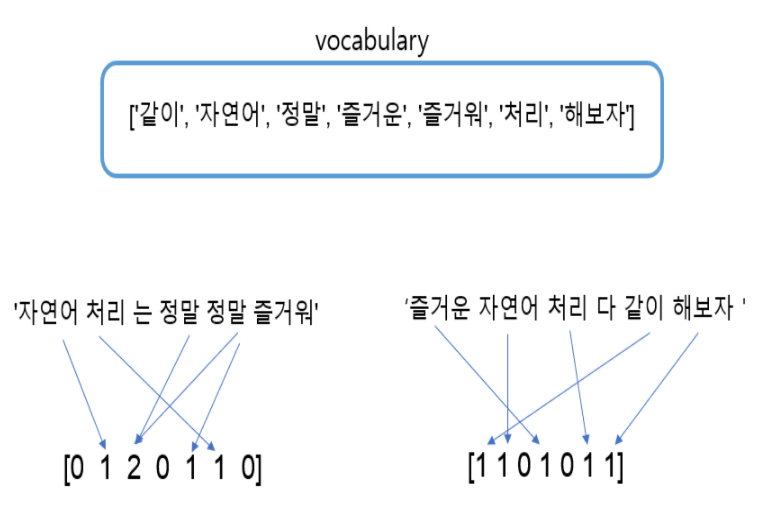

- **벡터화 결과** 각 문장은 **vocabulary의 인덱스(vectorizer의 feature 순서)**를 기준으로 **카운트가 정수로 표시**된 것을 알 수 있음. 아쉬운 점은 sklearn의 *CountVectorizer는 한 글자는 자동으로 제거*한다는 점.
- **또한, 이 부분에서 형태소 분석기의 중요성에 대해서 알 수 있음. '즐거운'과 '즐거워'는 같은 의미를 갖는 토큰이지만 Okt는 이를 구분해주지 못해서 다른 토큰으로 분리가 되었음. 이는 모델에서 같은 의미의 토큰을 다르게 학습할 수 있음을 의미함.** 

### 3. TfIdf

- TfIdf의 핵심은 2가지
1. **단어가 몇 번 등장했는지**에 대한 정보
2. **어떤 단어가 언급된 문서의 수가 적다면** ***그 단어***는 문서를 분류하는 데 있어서 중요한 단어
- 즉, **등장 횟수도 많고 문서 분별력 있는 단어들을 점수화하여 벡터화**한 것이 **TfIdf 기법**.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0)
tfidf_vectorizer = tfidf.fit_transform(tokens)

# tf-idf dictionary
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)
print(tfidf_vectorizer.toarray())

['같이', '자연어', '정말', '즐거운', '즐거워', '처리', '해보자']
[[0.         0.29017021 0.81564821 0.         0.4078241  0.29017021
  0.        ]
 [0.49922133 0.35520009 0.         0.49922133 0.         0.35520009
  0.49922133]]


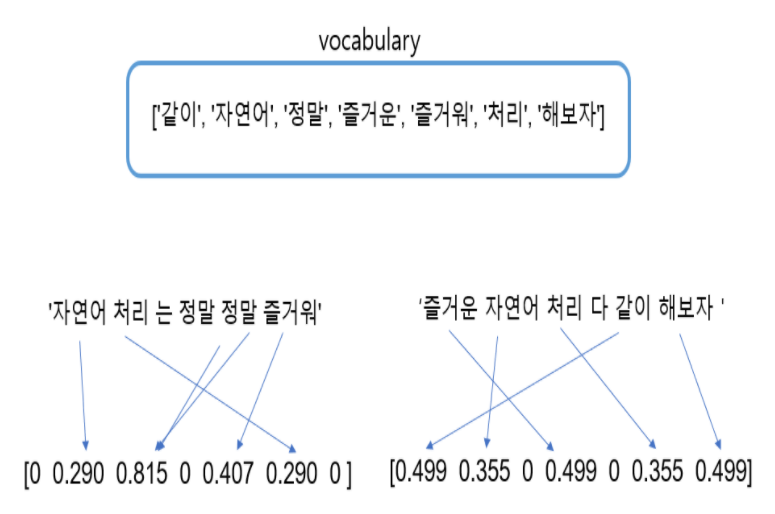

Count Vectorization과 동일한 방법이지만 **단어들에 대한 가중치가 다르게 표시**됨. (Tf-Idf 참고 : https://donghwa-kim.github.io/TFIDF.html)

### 4. Padding

- 여기서 생기는 궁금증 : 우리가 사용하던 모델들은 DataFrame 형식의 row별 동일한 column수를 갖는데 NLP에서는 row별(문장별) column(토큰의 개수)가 같지 않아도 되는건가?
- **Padding이란** : 기본적으로 문장의 길이를 동일하게 맞춰줘야 하는데, **문장의 길이를 맞춰주기 위해 부족한 길이만큼 0을 채워넣는 것**을 **Padding**이라고 부름.

### 5. 대회 적용

이번 대회에서는 <u>특별한 vectorization 기법을 사용하지 않고</u> **keras의 texts_to_sequences를 통한 정수화만 진행**해줘도 정확도를 얻을 수 있음.

In [42]:
import os

os.getcwd()
# os.chdir('drive/MyDrive/NLP/Dacon_NH competition/data/')

'/content/drive/My Drive/NLP/Dacon_NH competition/data'

In [43]:
import pandas as pd

train = pd.read_csv('news_train_preprocessing.csv')
train.head()

,n_id,date,title,content,ord,info,new_article
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,"['이데일리', '현재', '코스닥', '기관', '억', '순', '매도']"
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,"['실적', '기반', '저가', '에', '매집', '해야', '할', '월', ..."
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,"['하', '이스', '탁론', '선취', '수수료', '없는', '월', '최저'..."
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,"['종합', '경제', '정보', '미디어', '이데일리', '무단', '전', '..."
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,"['전국', '적', '인', '소비', '붐', '조성', '에', '기여', '..."


In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=100):   # 여기 max_len에 가장 긴 문장의 길이를 넣기
  tokenizer = Tokenizer()                                   # keras의 vectorizing 함수 호출
  tokenizer.fit_on_texts(train_text)                        # train 문장에 fit
  train_X_seq = tokenizer.texts_to_sequences(train_text)    # 각 토큰들에 정수값 부여
  vocab_size = len(tokenizer.word_index) + 1                # 모델에 알려줄 vocabulary의 크기 계산(padding값 0을 포함해야 하므로 +1)
  print('vocab_size : ', vocab_size)
  X_train = pad_sequences(train_X_seq, maxlen = max_len)    # 설정한 문장의 최대 길이만큼 padding

  return X_train, vocab_size, tokenizer

In [45]:
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = 100)

vocab_size :  43500


In [18]:
train_X

array([[  0,   0,   0, ..., 119, 218, 494],
       [  0,   0,   0, ...,  28, 569,  39],
       [  0,   0,   0, ...,  62, 273, 311],
       ...,
       [  0,   0,   0, ..., 118, 147, 114],
       [  0,   0,   0, ..., 120, 112,  48],
       [  0,   0,   0, ..., 120, 112,  48]], dtype=int32)

In [19]:
train_X.shape

(118745, 100)

In [20]:
train_X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 308, 183, 691, 235, 119, 218, 494], dtype=int32)

- 그러나, **Vectorization** 방법들은 ***치명적인 단점***을 갖고 있기 때문에 **바로 모델에 넣고 훈련을 시작하면 안됨.**
- 이러한 문제를 해결해주는 것이 바로 **Embedding**!!